# 2.03e - Analysis of COB Peaks Overnight
This notebook identifies and analyises the peaks of carbohydrate intake (COB) during the overnight period, specifically between 22:00 and 06:00 the following day, for it to be included in the objective function. The analysis will focus on the number of peaks and their timing.

In [7]:

%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import time

from src.cob_analysis import Cob
from src.config import PROCESSED_DATA_DIR
from src.nights import Nights, consolidate_df_from_nights
from src.features import FeatureSet
from src.helper import normalise_overnight_time


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
df_all = pd.read_parquet(PROCESSED_DATA_DIR / 'night_clusters.parquet')
df_all['time'] = df_all.index.get_level_values('datetime').time

night_start = time(22, 0)
morning_end = time(6, 0)
sample_rate = 30
nights_objects = []
for zip_id, df_ind in df_all.groupby('id'):
    df_ind_reset = df_ind.reset_index(level='id', drop=True)
    nights_objects.append(
        Nights(df=df_ind_reset, zip_id=zip_id, night_start=night_start,
               morning_end=morning_end, sample_rate=sample_rate))

df_overnight = consolidate_df_from_nights(nights_objects)

Previous steps in the pre-processing workflow have dealt with missing values in the 'cob max' variable. This is important given what we understand from the lifecylce of COB data in that the patient will enter a value of their intake, and the system will then deprecate the value over time based on a pre-defined rate, personalised to the patient. If there is a missing reading in the deprecation slope (and we know NaNs to be more prevalent with COB than the IOB and BG variables), and these are due to equipment or signal error for instance, two peaks will be recorded where there should be only one, leading to an overestimation of the number of peaks.

In [3]:
features = FeatureSet(df_overnight, sample_rate=sample_rate)
features.add_cob_peaks()
df_with_peaks = features.get_full_df()
df_with_peaks['cob_peaks'].value_counts()

cob_peaks
0    14319
1      286
Name: count, dtype: int64

In [21]:
peaks_summarised = df_with_peaks.groupby(['cluster', 'time']).agg({'cob_peaks': 'sum', 'cob max': 'mean'})
peaks_summarised = peaks_summarised.reset_index()
peaks_summarised['time'] = peaks_summarised['time'].apply(lambda x: normalise_overnight_time(x, morning_end.hour))
peaks_summarised.set_index(['cluster', 'time'], inplace=True)

C:\.env\master_project\Lib\site-packages\seaborn\_base.py:1135: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  converter.update_units(seed_data)


TypeError: tz must be string or tzinfo subclass, not <matplotlib.category.UnitData object at 0x0000021C89EAAE90>.

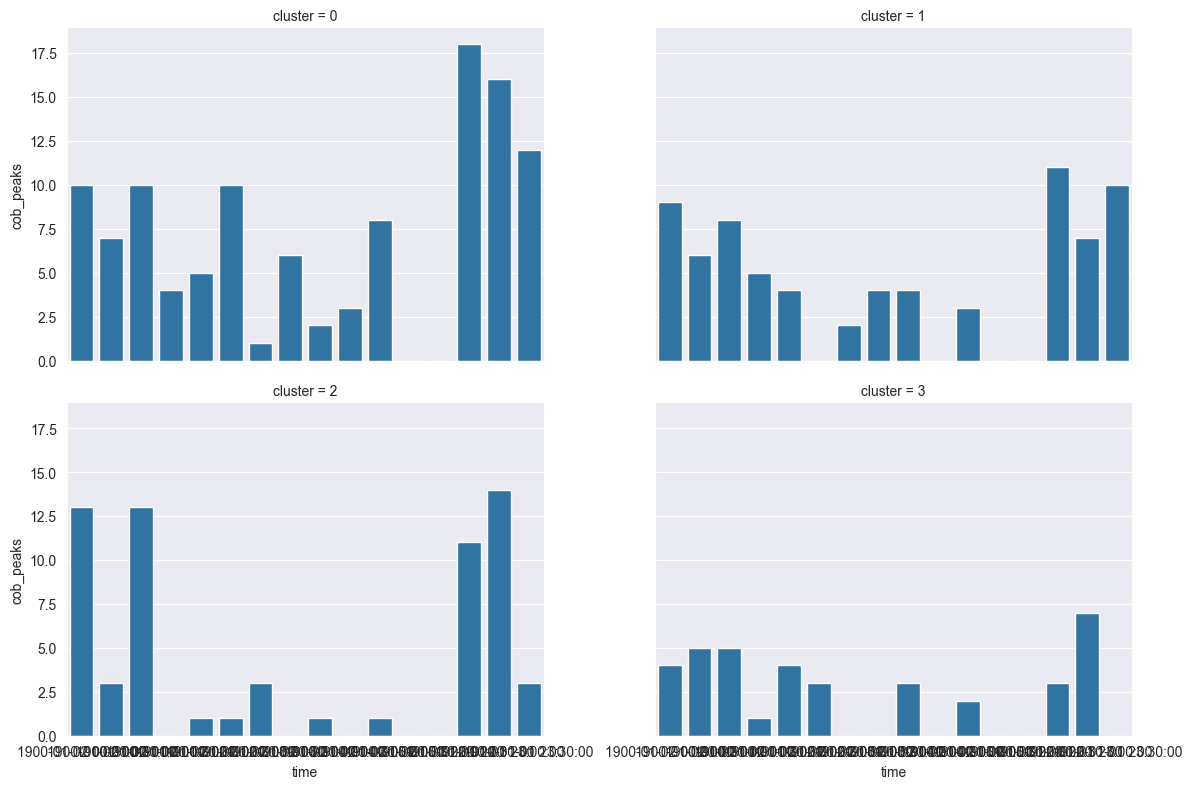

In [23]:
g = sns.FacetGrid(peaks_summarised.reset_index(), col='cluster', col_wrap=2, height=4, aspect=1.5)
g.map_dataframe(sns.barplot, x='time', y='cob_peaks')




ValueError: 'cob max' is not a valid format string (two color symbols)

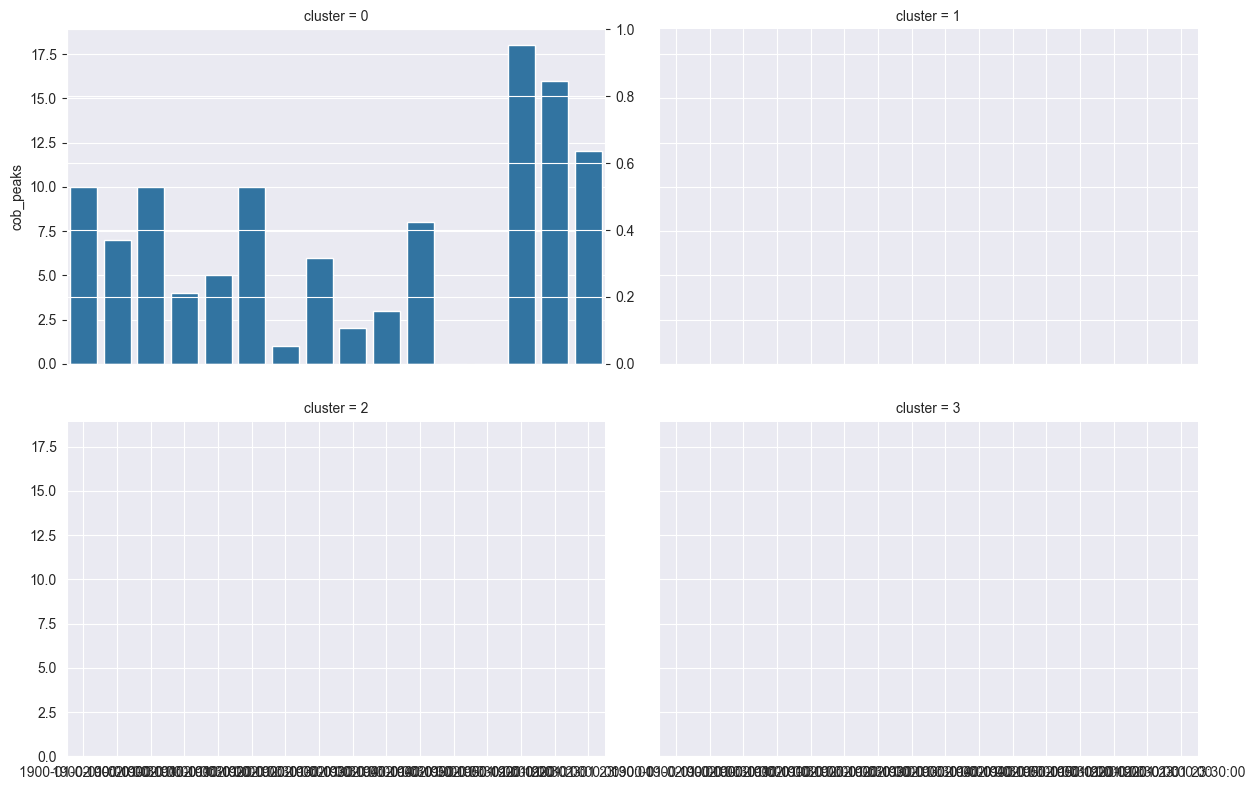

In [26]:
def plot_with_twin_axis(x, y1, y2, **kwargs):
    ax = plt.gca()
    ax2 = ax.twinx()
    sns.barplot(x=x, y=y1, ax=ax, **kwargs)
    ax2.plot(x, y2, color='red', marker='o', linewidth=2)
    ax2.set_ylabel('COB Max', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

# Create the FacetGrid
g = sns.FacetGrid(peaks_summarised.reset_index(), col='cluster', col_wrap=2, height=4, aspect=1.5)
g.map_dataframe(plot_with_twin_axis, x='time', y1='cob_peaks', y2='cob max')

# Set labels for primary axis
g.set_axis_labels('Time', 'COB Peaks')
g.set_titles('Cluster {col_name}')

plt.tight_layout()
plt.show()

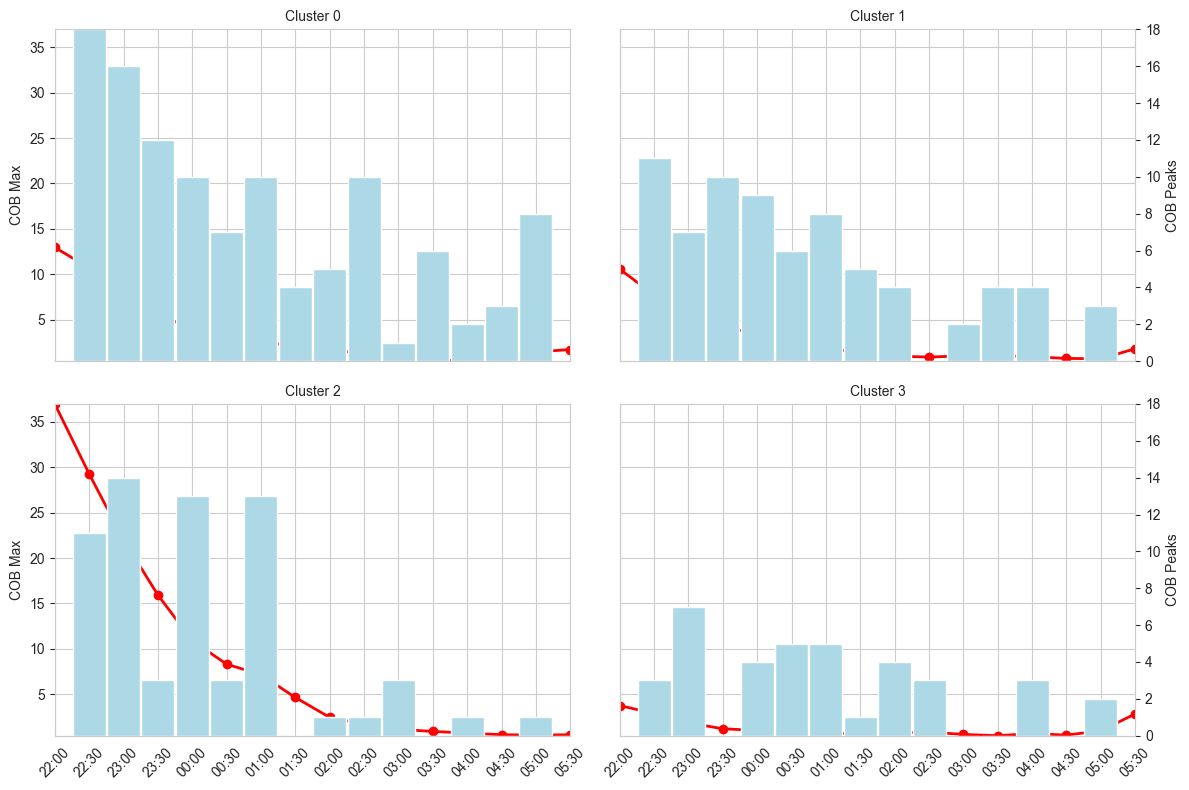

In [85]:
import matplotlib.dates as mdates

# Create the FacetGrid with bar plots first
g = sns.FacetGrid(peaks_summarised.reset_index().sort_values(by='time'), col='cluster', col_wrap=2, height=4, aspect=1.5)
# g.map_dataframe(sns.lineplot, x='time', y='cob max', marker='o', color='red', zorder=3)
cob_max_lim = peaks_summarised['cob max'].max()
cob_min_lim = peaks_summarised['cob max'].min()
peak_max_lim = peaks_summarised['cob_peaks'].max()
peak_min_lim = peaks_summarised['cob_peaks'].min()

# Add twin axes and line plots
for i, ax in enumerate(g.axes.flat):
    cluster_num = g.col_names[i % len(g.col_names)]
    cluster_data = peaks_summarised.reset_index()
    cluster_data = cluster_data[cluster_data['cluster'] == cluster_num].sort_values('time')

    if not cluster_data.empty:
        ax2 = ax.twinx()
        time_positions = mdates.date2num(cluster_data['time'])
        ax2.bar(time_positions, cluster_data['cob_peaks'], color='lightblue', label='COB Peaks', width=0.02, zorder=1)
        ax2.set_ylabel('COB Peaks')
        ax2.set_ylim(peak_min_lim, peak_max_lim)
        ax2.grid(False)


        ax.plot(cluster_data['time'], cluster_data['cob max'], color='red', marker='o', linewidth=2, zorder=10)
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=30))
        ax.tick_params(axis='x', rotation=45)
        ax.set_ylabel('COB Max')
        ax.set_ylim(cob_min_lim, cob_max_lim)
        ax.set_xlim(cluster_data['time'].min(), cluster_data['time'].max())
        ax.tick_params(axis='y')

        if i % 2 != 0:  # Right column - hide left y-axis (ax)
            ax.set_ylabel('')
            ax.tick_params(axis='y', left=False, labelleft=False)
        if i % 2 == 0:  # Left column - hide right y-axis (ax2)
            ax2.set_ylabel('')
            ax2.tick_params(axis='y', right=False, labelright=False)

g.set_titles('Cluster {col_name}')
plt.tight_layout()
plt.show()

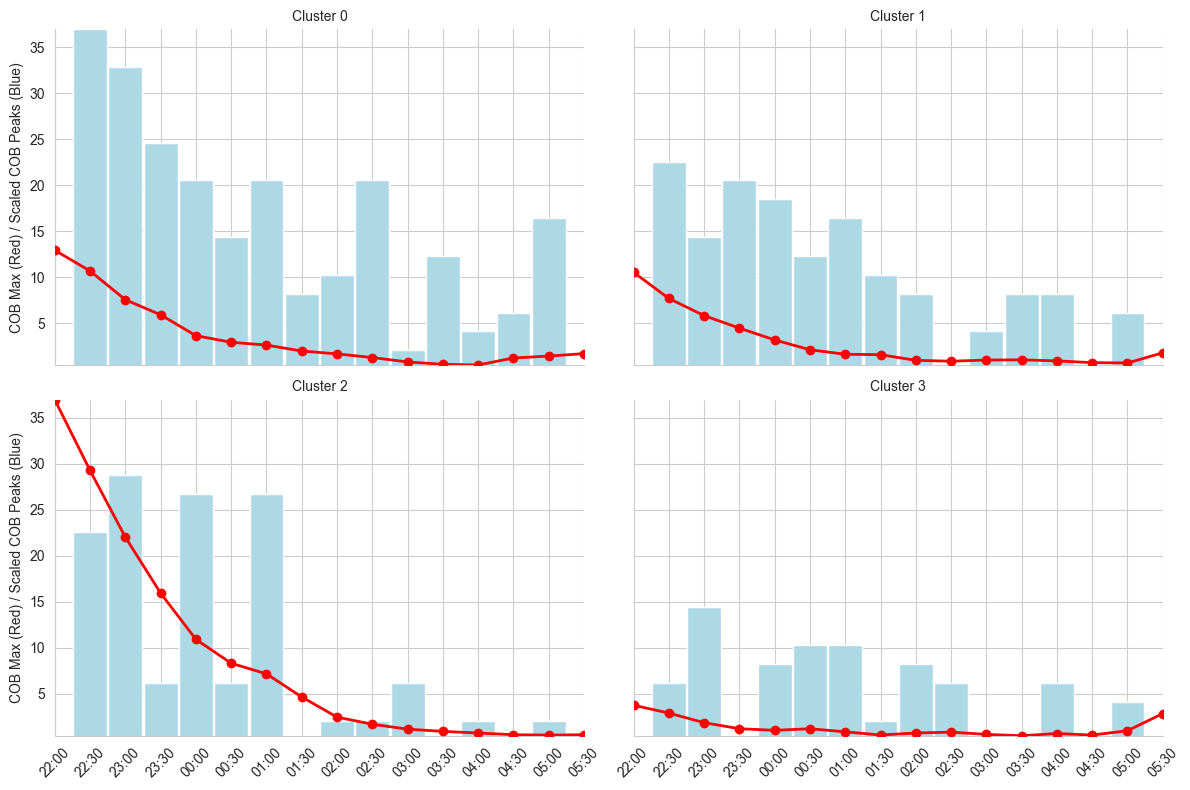

In [86]:
g = sns.FacetGrid(peaks_summarised.reset_index().sort_values(by='time'), col='cluster', col_wrap=2, height=4, aspect=1.5)
cob_max_lim = peaks_summarised['cob max'].max()
cob_min_lim = peaks_summarised['cob max'].min()
peak_max_lim = peaks_summarised['cob_peaks'].max()
peak_min_lim = peaks_summarised['cob_peaks'].min()

for i, ax in enumerate(g.axes.flat):
    cluster_num = g.col_names[i % len(g.col_names)]
    cluster_data = peaks_summarised.reset_index()
    cluster_data = cluster_data[cluster_data['cluster'] == cluster_num].sort_values('time')

    if not cluster_data.empty:
        # Scale the peaks to the cob max range for plotting
        scaled_peaks = cluster_data['cob_peaks'] * (cob_max_lim / peak_max_lim)

        time_positions = mdates.date2num(cluster_data['time'])
        ax.bar(time_positions, scaled_peaks, color='lightblue', label='COB Peaks', width=0.02, zorder=1)
        ax.plot(cluster_data['time'], cluster_data['cob max'], color='red', marker='o', linewidth=2, zorder=10)

        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=30))
        ax.tick_params(axis='x', rotation=45)
        ax.set_ylabel('COB Max (Red) / Scaled COB Peaks (Blue)')
        ax.set_ylim(cob_min_lim, cob_max_lim)
        ax.set_xlim(cluster_data['time'].min(), cluster_data['time'].max())

g.set_titles('Cluster {col_name}')
plt.tight_layout()
plt.show()

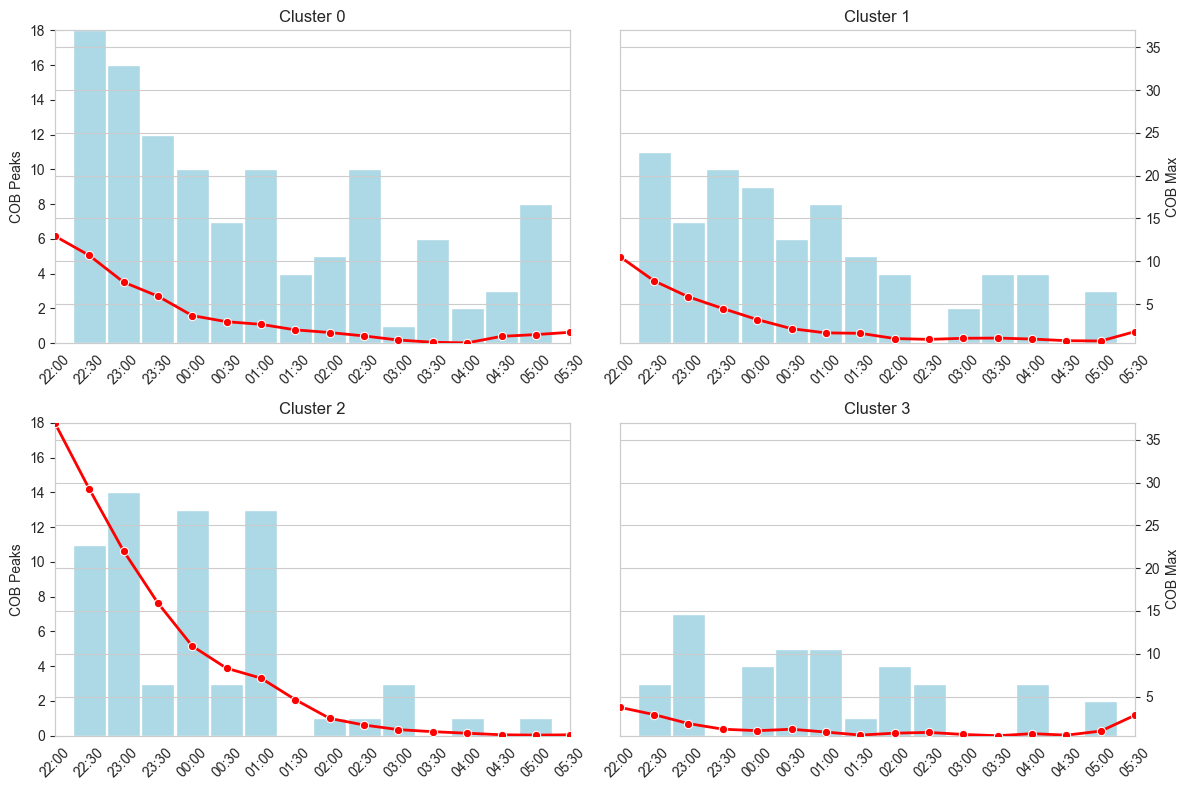

In [103]:
import matplotlib.dates as mdates

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
axes = axes.flatten()

cob_max_lim = peaks_summarised['cob max'].max()
cob_min_lim = peaks_summarised['cob max'].min()
peak_max_lim = peaks_summarised['cob_peaks'].max()
peak_min_lim = peaks_summarised['cob_peaks'].min()

for i, (cluster_num, cluster_data) in enumerate(peaks_summarised.groupby('cluster')):
    ax1 = axes[i]
    cluster_data.reset_index(inplace=True)

    if not cluster_data.empty:
        ax1.bar(cluster_data['time'], cluster_data['cob_peaks'], color='lightblue',
                width=0.02, zorder=1, label='COB Peaks')
        ax1.set_ylabel('COB Peaks')
        ax1.set_ylim(peak_min_lim, peak_max_lim)
        ax1.grid(False)

        ax2 = ax1.twinx()
        sns.lineplot(data=cluster_data, x='time', y='cob max', color='red',
                marker='o', linewidth=2, zorder=10, label='COB Max', legend=False)
        ax2.set_ylabel('COB Max')
        ax2.set_ylim(cob_min_lim, cob_max_lim)

        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        ax1.xaxis.set_major_locator(mdates.MinuteLocator(interval=30))
        ax1.set_xlim(cluster_data['time'].min(), cluster_data['time'].max())
        ax1.tick_params(axis='x', rotation=45)

        if i % 2 != 0:
            ax1.set_ylabel('')
            ax1.tick_params(axis='y', left=False, labelleft=False)
        if i % 2 == 0:
            ax2.set_ylabel('')
            ax2.tick_params(axis='y', right=False, labelright=False)

    ax1.set_title(f'Cluster {cluster_num}')

plt.tight_layout()
plt.show()

In [100]:
peaks_summarised.sort_index()

cob_peaks    cob max
cluster time                                     
0       1900-01-01 22:00:00          0  12.945312
        1900-01-01 22:30:00         18  10.687259
        1900-01-01 23:00:00         16   7.560784
        1900-01-01 23:30:00         12   5.919231
        1900-01-02 00:00:00         10   3.648855
...                                ...        ...
3       1900-01-02 03:30:00          0   0.421053
        1900-01-02 04:00:00          3   0.662281
        1900-01-02 04:30:00          0   0.488987
        1900-01-02 05:00:00          2   0.964758
        1900-01-02 05:30:00          0   2.828947

[64 rows x 2 columns]